In [2]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [4]:
import cv2
def read_data_bananas(is_train=True):
    """ 读取香蕉检测数据集，返回images、targets """
    data_dir = d2l.download_extract('banana-detection')
    csv_name = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_name)
    csv_data = csv_data.set_index('img_name')   # 设置索引，官方文档讲的比较清楚
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        # images.append(torchvision.io.read_image(
        #     os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')
        # ))
        img = cv2.imread(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', img_name))
        # img = img[:, :, ::-1]     # 报错
        # print(f'before {type(img)}')
        img = torch.from_numpy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB, img))
        # print(f'after {img}')
        images.append(img)
        targets.append(list(target))    # target包含(类别，x1,y1, x2,y2)
    return images, torch.tensor(data=targets).unsqueeze(1) / 256

In [5]:
class BananasDataset(torch.utils.data.Dataset):
    """ 自定义数据集类 主要用于获取数据[not for batch]
        __init__()、__getitem__()、__len__()应该是自定义数据集类主要实现的功能，自己要记住 """
    def __init__(self, is_train=True) -> None:
        self.features, self.labels = read_data_bananas(is_train)    # 返回数据集所有数据的tensor
        print(f'read {len(self.features)} {"training examples" if is_train else "validation examples"}')
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

In [6]:
def load_data_bananas(batch_size):
    """ 定义train_iter、val_iter，这样就能以batch为单位获取数据了 """
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size, shuffle=False)
    return train_iter, val_iter

In [7]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))

read 1000 training examples
read 100 validation examples


In [8]:
batch[0].shape, batch[1].shape

(torch.Size([32, 256, 256, 3]), torch.Size([32, 1, 5]))

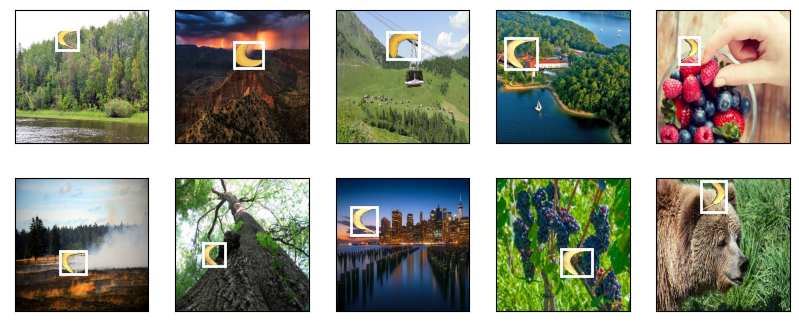

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

imgs = (batch[0][0:10]) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])